In [ ]:
import numpy as np
import pandas as pd
import numba
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os
import glob

# Set random seed
np.random.seed(42)

# 1. Numba Optimized Functions (Adapted from Original)

In [ ]:
@numba.njit(parallel=True, fastmath=False) 
def sort_2d_array(x):
    n,m=np.shape(x)
    for row in numba.prange(n):
        x[row]=np.sort(x[row])
    return x

@numba.njit(parallel=True, fastmath=False) 
def fepls_numba(X,Y,y_matrix,tau): 
    # X of size (N,n,d) and Y of size (N,n)
    # y_matrix of shape (N,n)
    # tau is the tail index of psi
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    out=np.zeros((N,d))
    for j in numba.prange(d):
        aux = np.multiply(X[:,:,j],Y**tau) 
        out2 = np.multiply(aux,np.greater_equal(Y,y_matrix)) 
        out[:,j]= np.sum(out2,axis=1)/n 
    norms=np.sqrt(np.sum(out**2,axis=1)/d) 
    out2 =  out * (norms.reshape((norms.size, 1)))**(-1)
    return out2 

def fepls(X,Y,y_matrix,tau):
    # Wrapper for non-numba usage if needed, but we use the numba one mostly
    return fepls_numba(X,Y,y_matrix,tau)

@numba.njit(parallel=True, fastmath=False) 
def concomittant_corr(X,Y,Y_sort_index,tau,m): 
    N = X.shape[0]
    n = X.shape[1]
    d = X.shape[2]
    out = np.zeros((N,m))
    YY=np.copy(Y)
    Y_sort=sort_2d_array(YY)
    for k in numba.prange(m):
        y_array = np.zeros((N,n,k+1))
        aux = np.zeros((N,k+1))
        aux3 = Y_sort[:,n-k-1:] 
        for i in numba.prange(k):
            y_array[:,0,i] = Y_sort[:,n-i-1]
            for j_2 in numba.prange(N):
                y_array[j_2,:,i] = y_array[j_2,0,i]
            hat_beta = fepls_numba(X,Y,y_array[:,:,i],tau) 
            for j_1 in numba.prange(N):
                i_c = Y_sort_index[j_1,i]
                aux[j_1,i]=(1/d)*np.sum(np.multiply(hat_beta[j_1,:],X[j_1,i_c,:]))
                out[j_1,k]= np.corrcoef(aux3[j_1,:],aux[j_1,:])[0,1]
    return out

def bitcoin_concomittant_corr(X,Y,tau,m): 
    # Simplified version for N=1 case usually used in main loop
    N = X.shape[0]
    n = X.shape[1]
    d = X.shape[2]
    out = np.zeros((m))
    Y_sort=np.sort(Y,axis=1)
    Y_sort_index = np.argsort(Y,axis=1)
    for k in range(m):
        y_array = np.zeros((N,n,k+1))
        aux = np.zeros((k+1))
        aux3 = Y_sort[0,n-k-1:] 
        for i in range(k):
            y_array[:,:,i] = (Y_sort[0,n-i-1])*np.ones((1,n))
            hat_beta = fepls(X,Y,y_array[:,:,i],tau) 
            i_c = Y_sort_index[0,i]
            aux[i]=(1/d)*np.sum(np.multiply(hat_beta[0,:],X[0,i_c,:]))
            # Check for NaN or constant input to corrcoef
            if np.std(aux3) == 0 or np.std(aux) == 0:
                 out[k] = 0
            else:
                 out[k]= np.corrcoef(aux3,aux)[0,1]
    return np.abs(out)

@numba.njit(parallel=True, fastmath=False)
def get_hill_estimator(ordered_data):
    logs = np.log(ordered_data)
    logs_cumsum = np.cumsum(logs[:-1])
    k_vector = np.arange(1, len(ordered_data))
    m1 = (1./k_vector)*logs_cumsum - logs[1:]
    return m1

def Exponential_QQ_Plot_1D(Y,k):
    n=Y.shape[1]
    out=np.zeros((k))
    out2=np.zeros((k))
    YY=np.sort(Y,axis=1)
    for i in range(k):
        out[i]=np.log((k+1)/(i+1))
        out2[i]=  np.log(YY[0,n-i-1])-np.log(YY[0,-k])
    return np.column_stack((out,out2))

@numba.njit(parallel=False, fastmath=False) 
def Gaussian_kernel(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-0.5*np.power(x,2))

@numba.njit(parallel=True, fastmath=False) 
def Epanechnikov_kernel_1D(x):
    out = np.zeros_like(x)
    x=np.asarray(x)
    for i in numba.prange(x.shape[0]):
        if x[i]<=1 and x[i]>=-1: # Fixed range
            out[i] = np.multiply(0.75,1-np.power(x[i],2))
        else:
            out[i]=0
    return out

@numba.njit(parallel=True, fastmath=False) 
def univariate_Nadaraya_weight_2D(X_2D,dimred,x_func,x,h,type,kernel): 
    d=x_func.shape[0]
    # type 2: Y|(X,dimred) = x
    if kernel == 1:
        K_h=Epanechnikov_kernel_1D((np.dot(X_2D,dimred)/d-x)/h) 
    if kernel == 2:
        K_h=Gaussian_kernel((np.dot(X_2D,dimred)/d-x)/h) 
    
    sum_Kh = np.sum(K_h)
    if sum_Kh == 0:
        return np.ones_like(K_h) / K_h.shape[0]
    return K_h/sum_Kh

@numba.njit(parallel=True, fastmath=False) 
def functional_Nadaraya_weight_2D(X_2D,x_func,h,kernel): 
    d=x_func.shape[0]
    aux = (X_2D-x_func*np.ones(d))**2 
    norm = np.sqrt((1/d)*np.sum(aux,axis=1)) 
    if kernel == 1:
        K_h= Epanechnikov_kernel_1D(norm/h) 
    if kernel == 2:
        K_h= Gaussian_kernel(norm/h)
        
    sum_Kh = np.sum(K_h)
    if sum_Kh == 0:
        return np.ones_like(K_h) / K_h.shape[0]
    return K_h/sum_Kh

@numba.njit(parallel=True, fastmath=False)   
def weighted_quantile(data,weight,alpha): 
    sorter = np.argsort(data)
    data = data[sorter]
    weight = weight[sorter]
    weighted_quantiles = np.cumsum(weight) - 0.5 * weight
    weighted_quantiles /= np.sum(weight)
    return np.interp(alpha, weighted_quantiles, data)

@numba.njit(parallel=True, fastmath=False) 
def tail_index_gamma_estimator_2D(Y,weight,alpha,J): 
    subdivision=np.array([(1/s) for s in np.arange(1,J+1)] )
    quantile_data2=weighted_quantile(Y[0,:],weight,alpha) 
    aux=np.zeros((J))
    for j in numba.prange(J):
        quantile_data1=weighted_quantile(Y[0,:],weight,1-subdivision[j]*(1-alpha))
        val = np.log(quantile_data1)-np.log(quantile_data2)
        aux[j] = val / -np.sum(np.log(subdivision))
    return np.sum(aux)

@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample_new(X,Y,dimred,x_func,alpha,h_univ_vector,h_func_vector): 
    n=X.shape[1]
    d=X.shape[2]
    # Grid of scalar values <X, x_func>
    proj_vals = np.dot(X[0,:,:],x_func)/d
    S_grid = np.linspace(np.min(proj_vals),np.max(proj_vals),100) # Reduced to 100 for speed
    out = np.zeros((S_grid.shape[0],2))
    
    for p in numba.prange(S_grid.shape[0]):
        # Univariate Weight
        K_h=Gaussian_kernel((np.dot(X[0,:,:],dimred)/d-(np.dot(x_func,dimred)/d)*S_grid[p])/h_univ_vector[0]) # Simplification: using const h
        weight_univ=K_h/np.sum(K_h)        
        
        # Functional Weight
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],S_grid[p]*x_func,h_func_vector[0],2)
        
        out[p,0]=weighted_quantile(Y[0,:],weight_univ,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out, S_grid

@numba.njit(parallel=True, fastmath=False) 
def beta_func(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.sin(2*np.pi*grid)**2)/d)
    return np.sin(2*np.pi*grid)/norm

# 2. Data Loading and "Functional" Preprocessing

In [ ]:
def load_stooq_file(filepath):
    """Parses a single Stooq .txt file into a clean DataFrame."""
    try:
        df = pd.read_csv(filepath)
        # Stooq format: <TICKER>,<PER>,<DATE>,<TIME>,...
        # Columns might be standard or capitalized.
        df.columns = [c.replace('<','').replace('>','').lower() for c in df.columns]
        
        # Combine DATE and TIME into a DateTimeIndex
        # DATE is usually YYYYMMDD, TIME is HHMMSS
        df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str).str.zfill(6), format='%Y%m%d %H%M%S')
        df = df.set_index('datetime')
        
        # Keep relevant columns
        return df[['close', 'vol']]
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

def create_functional_data(df_dict, ticker_name, time_grid=None):
    """
    Transforms 5-min time series into a Matrix of shape (Days, TimePoints).
    Row i = Intraday price curve of Day i.
    """
    df = df_dict[ticker_name]
    
    # 1. Create a Date column and Time column
    df = df.copy()
    df['Date'] = df.index.date
    df['Time'] = df.index.time
    
    # 2. If no time_grid provided, determine the common intraday times
    # Standard BSE hours 09:00 to 17:00 (approx)
    if time_grid is None:
        # We pick the most common timestamps found in the data
        time_counts = df['Time'].value_counts()
        # Filter times that appear in at least 50% of days to exclude artifacts
        n_days = df['Date'].nunique()
        common_times = time_counts[time_counts > n_days * 0.5].index.sort_values()
        time_grid = common_times
    
    # 3. Pivot: Rows=Date, Cols=Time, Values=Close
    # We need to reindex to ensure exactly the time_grid columns
    pivot_df = df.pivot_table(index='Date', columns='Time', values='close')
    
    # Reindex columns to the standard grid, filling missing intraday values 
    # (forward fill first for missing ticks, then backfill)
    pivot_df = pivot_df.reindex(columns=time_grid)
    pivot_df = pivot_df.ffill(axis=1).bfill(axis=1)
    
    # Drop days that are still completely empty or have too many missing values
    pivot_df = pivot_df.dropna()
    
    return pivot_df, time_grid

# Define path
DATA_DIR = "../../data/stooq/hungary/5_hu_txt/data/5 min/hu/bse stocks/"

# List of all main BSE stocks found in the directory as possible targets
targets = [
    '4ig.hu.txt', 'akko.hu.txt', 'alteo.hu.txt', 'amixa.hu.txt', 'any.hu.txt',
    'appeninn.hu.txt', 'astrasun.hu.txt', 'autowallis.hu.txt', 'bet.hu.txt',
    'bif.hu.txt', 'chome.hu.txt', 'cigpannonia.hu.txt', 'civita.hu.txt', 'delta.hu.txt',
    'dmker.hu.txt', 'dunahouse.hu.txt', 'enefi.hu.txt',
    'epduferr.hu.txt', 'eproliusia.hu.txt', 'esense.hu.txt', 'forras_oe.hu.txt',
    'forras_t.hu.txt', 'futuraqua.hu.txt', 'glia.hu.txt', 'gloster.hu.txt', 'goodwillphrm.hu.txt',
    'gopd.hu.txt', 'granit.hu.txt', 'gspark.hu.txt', 'kermannit.hu.txt', 'masterplast.hu.txt',
    'mbhbank.hu.txt', 'mbhjb.hu.txt', 'megakran.hu.txt', 'mol.hu.txt', 'mtelekom.hu.txt',
    'multihome.hu.txt', 'nap.hu.txt', 'naturland.hu.txt', 'navigator.hu.txt', 'nordgeneral.hu.txt',
    'nutex.hu.txt', 'o3pnrs.hu.txt', 'opus.hu.txt', 'ormester.hu.txt', 'otp.hu.txt',
    'pannergy.hu.txt', 'pensum.hu.txt', 'polyduct.hu.txt', 'raba.hu.txt', 'richter.hu.txt',
    'splus.hu.txt', 'strt.hu.txt', 'sundell.hu.txt', 'ubm.hu.txt',
    'vertikal.hu.txt', 'vig.hu.txt', 'vvt.hu.txt', 'waberers.hu.txt'
]
data_store = {}
for t in targets:
    path = os.path.join(DATA_DIR, t)
    if os.path.exists(path):
        print(f"Loading {t}...")
        data_store[t] = load_stooq_file(path)
    else:
        print(f"File not found: {path}")

Loading 4ig.hu.txt...
Loading akko.hu.txt...
Loading alteo.hu.txt...
Loading amixa.hu.txt...
Loading any.hu.txt...
Loading appeninn.hu.txt...
Loading astrasun.hu.txt...
Loading autowallis.hu.txt...
Loading bet.hu.txt...
Loading bif.hu.txt...
Loading chome.hu.txt...
Loading cigpannonia.hu.txt...
Loading civita.hu.txt...
Loading delta.hu.txt...
Loading dmker.hu.txt...
Loading dunahouse.hu.txt...
Loading enefi.hu.txt...
Loading epduferr.hu.txt...
Loading eproliusia.hu.txt...
Loading esense.hu.txt...
Loading forras_oe.hu.txt...
Loading forras_t.hu.txt...
Loading futuraqua.hu.txt...
Loading glia.hu.txt...
Loading gloster.hu.txt...
Loading goodwillphrm.hu.txt...
Loading gopd.hu.txt...
Loading granit.hu.txt...
Loading gspark.hu.txt...
Loading kermannit.hu.txt...
Loading masterplast.hu.txt...
Loading mbhbank.hu.txt...
Loading mbhjb.hu.txt...
Loading megakran.hu.txt...
Loading mol.hu.txt...
Loading mtelekom.hu.txt...
Loading multihome.hu.txt...
Loading nap.hu.txt...
Loading naturland.hu.txt...


# 3. Alignment and Transformation

In [ ]:
# Create functional data for OTP, MOL, RICHTER
# We need a common time grid for all of them to be comparable
# Let's inspect OTP first to get a grid
if 'otp.hu.txt' in data_store:
    _, master_grid = create_functional_data(data_store, 'otp.hu.txt')
    print(f"Established master time grid with {len(master_grid)} points per day.")
else:
    # Fallback
    master_grid = None

# Create matrices
func_data = {}
for t in data_store.keys():
    mat, _ = create_functional_data(data_store, t, time_grid=master_grid)
    # Convert Prices to Log-Returns
    # Log-Return curve R(t) = log(P(t)) - log(P(0)) or similar. 
    # Standard FDA often uses log-returns relative to opening, or just raw log prices normalized.
    # The original script used: np.diff(np.log(prices)) which gives instantaneous returns.
    # Let's do cumulative log returns for the curve shape: log(P_t / P_open)
    
    # Method 1: Daily Curve of Log Prices normalized to start at 0
    log_prices = np.log(mat.values)
    # Subtract the first column from all columns (start at 0)
    curves = log_prices - log_prices[:, 0:1]
    
    # Method 2: Instantaneous returns (diff) - closer to original script logic
    # The original script used `np.diff` on the whole series then meshed.
    # Here we take diff along the time axis.
    diff_curves = np.diff(log_prices, axis=1)
    
    func_data[t] = {
        'dates': mat.index,
        'curves': diff_curves, # Shape (N_days, d-1)
        'max_return': np.max(diff_curves, axis=1) # The scalar extreme for that day
    }
    print(f"Processed {t}: {diff_curves.shape} days x points")

Established master time grid with 96 points per day.
Processed 4ig.hu.txt: (103, 95) days x points
Processed akko.hu.txt: (103, 95) days x points
Processed alteo.hu.txt: (103, 95) days x points
Processed amixa.hu.txt: (77, 95) days x points
Processed any.hu.txt: (103, 95) days x points
Processed appeninn.hu.txt: (103, 95) days x points
Processed astrasun.hu.txt: (47, 95) days x points
Processed autowallis.hu.txt: (103, 95) days x points
Processed bet.hu.txt: (87, 95) days x points
Processed bif.hu.txt: (100, 95) days x points
Processed chome.hu.txt: (33, 95) days x points
Processed cigpannonia.hu.txt: (102, 95) days x points
Processed civita.hu.txt: (27, 95) days x points
Processed delta.hu.txt: (103, 95) days x points
Processed dmker.hu.txt: (80, 95) days x points
Processed dunahouse.hu.txt: (103, 95) days x points
Processed enefi.hu.txt: (88, 95) days x points
Processed epduferr.hu.txt: (98, 95) days x points
Processed eproliusia.hu.txt: (23, 95) days x points
Processed esense.hu.txt

# 4. FEPLS Analysis: Multiple Pairs


--- Analyzing Pair: mol (X) -> otp (Y) ---


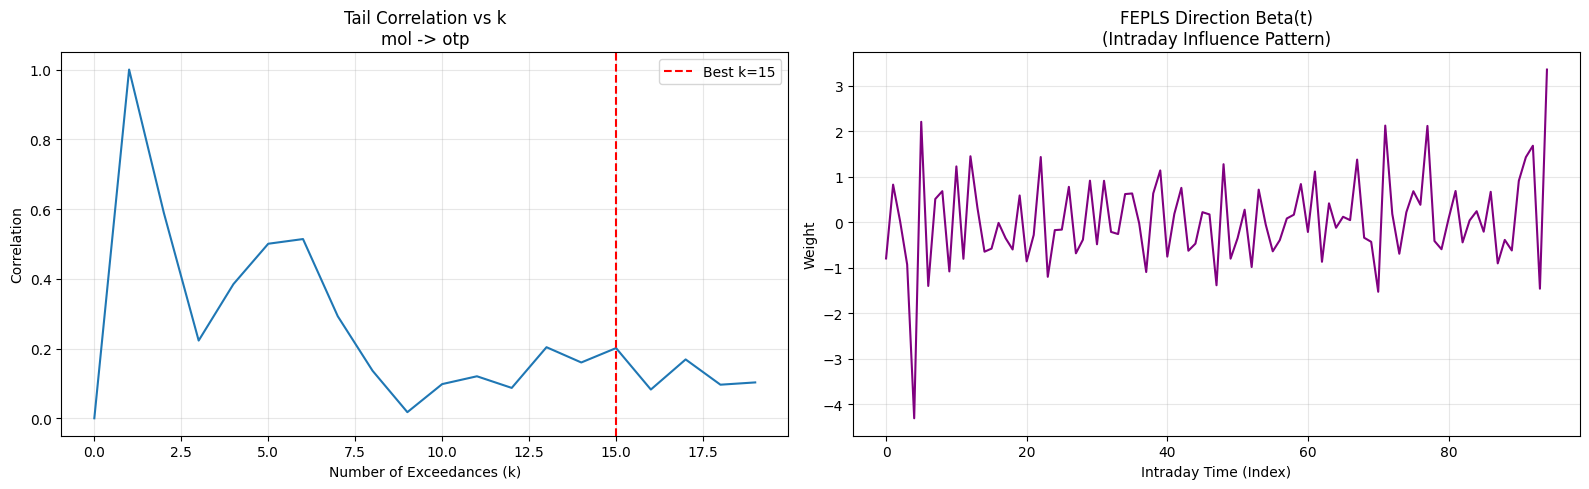


--- Analyzing Pair: otp (X) -> mol (Y) ---


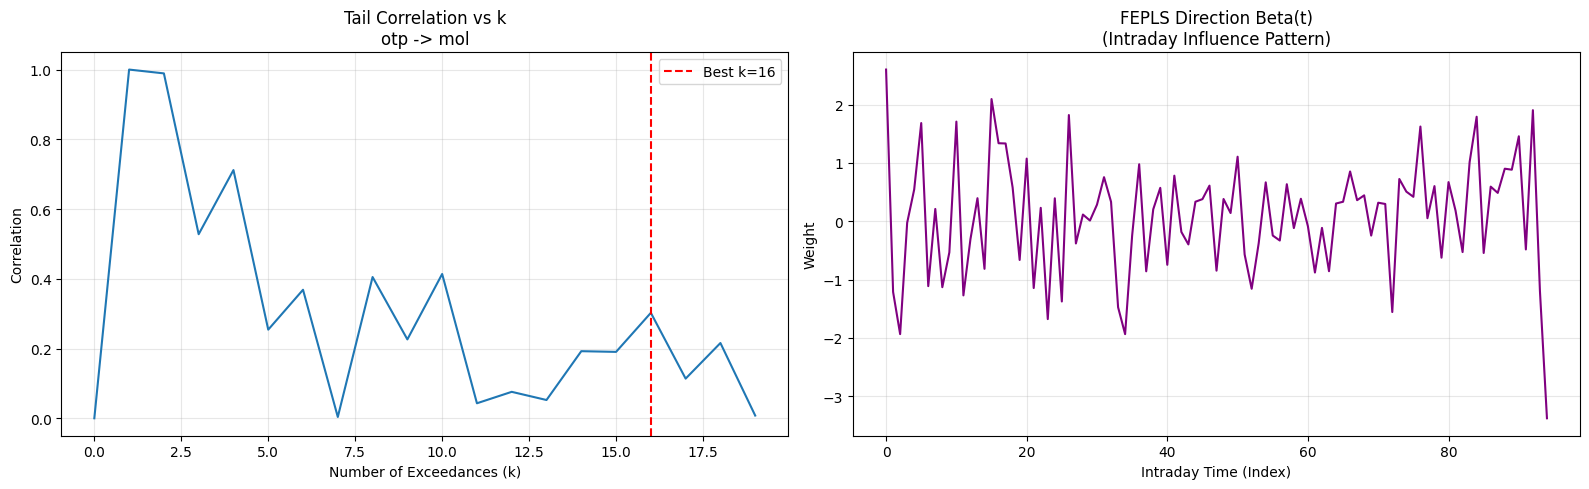


--- Analyzing Pair: richter (X) -> otp (Y) ---


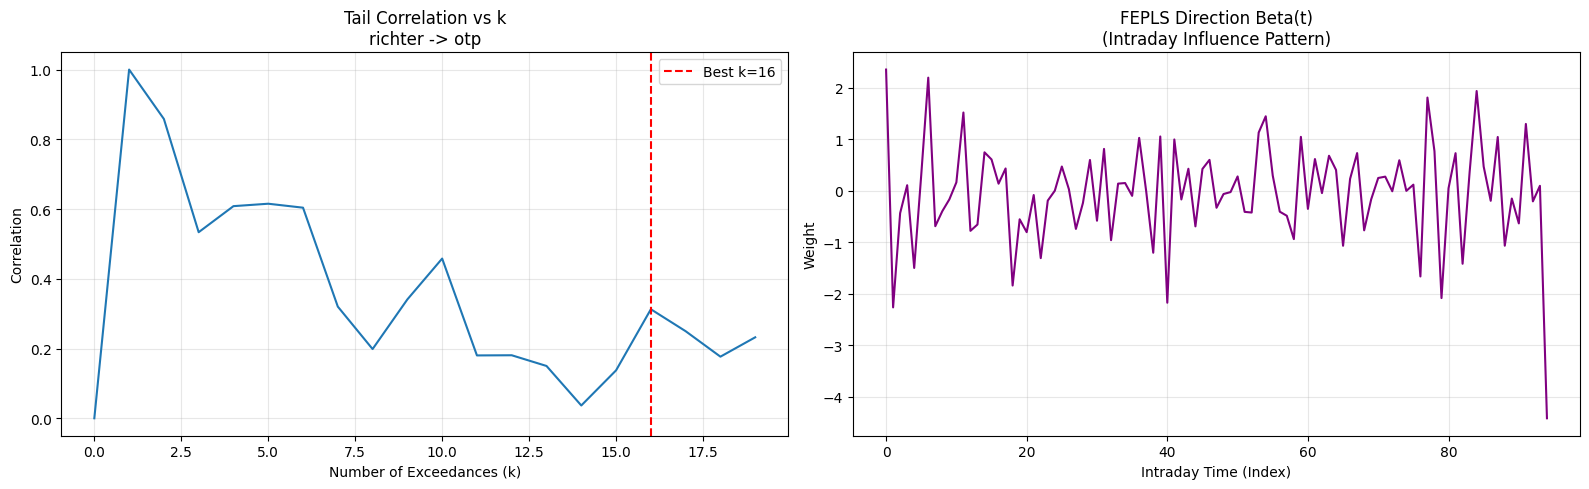


--- Analyzing Pair: otp (X) -> richter (Y) ---


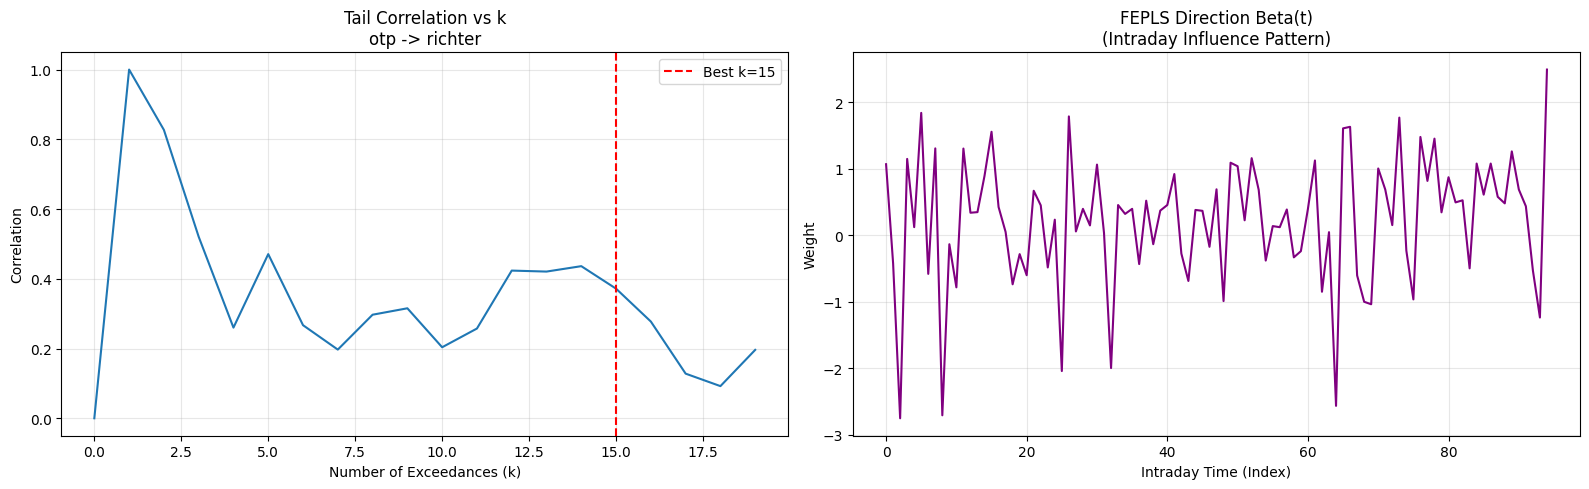

In [ ]:
# Define pairs to analyze (Predictor X, Target Y)
pairs_to_analyze = [
    ('mol.hu.txt', 'otp.hu.txt'),      # Energy predicting Banking
    ('otp.hu.txt', 'mol.hu.txt'),      # Banking predicting Energy
    ('richter.hu.txt', 'otp.hu.txt'),  # Pharma predicting Banking
    ('otp.hu.txt', 'richter.hu.txt'),  # Banking predicting Pharma
]

# Parameters
tau = 1.0
valid_k_start = 15

for ticker_X, ticker_Y in pairs_to_analyze:
    if ticker_X in func_data and ticker_Y in func_data:
        print(f"\n--- Analyzing Pair: {ticker_X[:-7]} (X) -> {ticker_Y[:-7]} (Y) ---")
        
        # Align Data
        common_dates = func_data[ticker_X]['dates'].intersection(func_data[ticker_Y]['dates'])
        idx_X = func_data[ticker_X]['dates'].isin(common_dates)
        idx_Y = func_data[ticker_Y]['dates'].isin(common_dates)
        
        X_data = func_data[ticker_X]['curves'][idx_X]
        Y_data = func_data[ticker_Y]['max_return'][idx_Y]
        
        # Reshape
        X_fepls = np.expand_dims(X_data, axis=0)
        Y_fepls = np.expand_dims(Y_data, axis=0)
        
        n_samples = Y_fepls.shape[1]
        d_points = X_fepls.shape[2]
        m_threshold = int(n_samples / 5)
        
        # 1. Correlation Curve
        corr_curve = bitcoin_concomittant_corr(X_fepls, Y_fepls, tau, m_threshold)
        
        # Find best k
        if len(corr_curve) > valid_k_start:
            best_k = np.argmax(corr_curve[valid_k_start:]) + valid_k_start
        else:
            best_k = 20
            
        # 2. FEPLS Direction (Beta)
        Y_sorted = np.sort(Y_fepls[0])[::-1]
        y_n = Y_sorted[best_k]
        y_matrix = y_n * np.ones_like(Y_fepls)
        
        E0 = fepls(X_fepls, Y_fepls, y_matrix, tau)
        beta_hat = E0[0,:]
        
        # --- Plotting ---
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        # Plot Correlation
        axes[0].plot(corr_curve)
        axes[0].axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
        axes[0].set_title(f'Tail Correlation vs k\n{ticker_X[:-7]} -> {ticker_Y[:-7]}')
        axes[0].set_xlabel('Number of Exceedances (k)')
        axes[0].set_ylabel('Correlation')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot Beta Curve
        axes[1].plot(beta_hat, color='purple')
        axes[1].set_title(f'FEPLS Direction Beta(t)\n(Intraday Influence Pattern)')
        axes[1].set_xlabel('Intraday Time (Index)')
        axes[1].set_ylabel('Weight')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"Skipping pair {ticker_X} -> {ticker_Y}: Data not in func_data and ticker_Y or ticker_X (Data Missing)")

K should be chosen wisely 